In [1]:
from numpy import array
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

2022-09-06 17:38:18.285175: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-06 17:38:18.285246: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [75]:
df = pd.read_csv('../raw_data/ratios.csv')
df

,Date,ALB_ZBRA,NRG_CPRT,DE_BXP,NRG_STE,NRG_XRAY,SO_NLOK,PEG_O
0,2020-08-31,0.311845,0.310544,2.548054,0.203834,0.727693,2.136432,0.882281
1,2020-09-01,0.332974,0.306303,2.687319,0.203522,0.722940,2.094566,0.855546
2,2020-09-02,0.332368,0.315056,2.629334,0.204743,0.734758,2.125291,0.872526
3,2020-09-03,0.339772,0.310060,2.534974,0.201707,0.728923,2.210971,0.848504
4,2020-09-04,0.356920,0.300754,2.536138,0.199887,0.707646,2.152835,0.854765
...,...,...,...,...,...,...,...,...
492,2022-08-15,0.813028,0.321488,4.111073,0.197467,1.123670,3.277218,0.920803
493,2022-08-16,0.814154,0.323634,4.118669,0.200499,1.158238,3.283272,0.933379
494,2022-08-17,0.815450,0.327442,4.154118,0.201342,1.191888,3.347435,0.935173
495,2022-08-18,0.816374,0.333768,4.222490,0.204492,1.196920,3.371537,0.950678


In [76]:
ratio = 'ALB_ZBRA'
A = df[['Date',ratio]]
A.set_index('Date',inplace=True)
A.head()

,ALB_ZBRA
Date,
2020-08-31,0.311845
2020-09-01,0.332974
2020-09-02,0.332368
2020-09-03,0.339772
2020-09-04,0.356920


In [77]:
Daily_ratio = A[ratio].to_list()

In [83]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

In [99]:
X,y = split_sequence(Daily_ratio,200,30)
X_train =X[0:X.shape[0]-1]
X_test = X[X.shape[0]-1:]
X_train.shape
X_test.shape
y.shape
y_train = y[0:y.shape[0]-1]
y_test = y[y.shape[0]-1:]


X_train.shape

(267, 200)

In [100]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], n_features))
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
X_train.shape

(267, 200, 1)

In [86]:
# define model
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(200, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(200, 1)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(50, activation='relu'))
model.add(Dense(30))
model.compile(optimizer='adam', loss='mse')


In [87]:
# fit model
model.fit(X_train, y_train, epochs=1000, verbose=0)


In [88]:
# demonstrate prediction
yhat = model.predict(X_test, verbose=0)
print(yhat)

[[0.7350004  0.75517905 0.7539702  0.7170357  0.742113   0.7153993
  0.72937405 0.73391145 0.73033196 0.7256184  0.71984696 0.7225187
  0.71405363 0.72268236 0.7129971  0.72725344 0.74215925 0.7438424
  0.75447464 0.7420984  0.7603387  0.75870514 0.81782246 0.82589406
  0.8581247  0.85271055 0.8554827  0.8614019  0.8395095  0.8463453 ]]


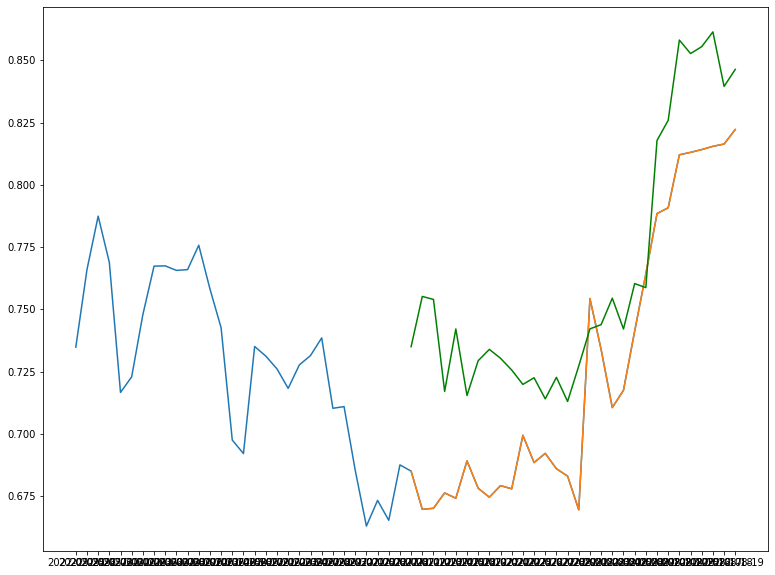

In [89]:
fig, ax = plt.subplots(1,1,figsize = (13,10))
ax.plot(A[ratio][-60:])
ax.plot(A.index[-30:],y_test[0])
ax.plot(A.index[-30:],yhat[0],c='green')

In [97]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [98]:
mean_absolute_percentage_error(y_test,yhat)

5.4636756902712875